## Feature Engineering (Continued from `EDA_1`)
**Import required packages & check working directory**

In [1]:
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import os
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA, SparsePCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import graph_fun

if os.getcwd()[-3:] == "src":
    os.chdir(os.path.dirname(os.getcwd()))
else:
    pass

**User defined parameters**

In [2]:
ticker = "CVX"
stock_data_path = "data/EDA/"
adj_daily_closing_path = "data/adjusted_daily_closing/"
adj_daily_dividend_path = "data/dividends/"
eda_data_path = "data/EDA/"
lead_days = 5

**Load adjusted daily closing and dividends**

In [3]:
daily_closing = pd.read_csv(os.path.abspath(os.path.join(adj_daily_closing_path, (ticker + ".csv"))))
daily_closing["date"] = pd.to_datetime(daily_closing["date"]).dt.date

daily_dividend = pd.read_csv(os.path.abspath(os.path.join(adj_daily_dividend_path, (ticker + "_ts.csv"))))
daily_dividend["date"] = pd.to_datetime(daily_dividend["date"]).dt.date

adj_closing_df = daily_closing[["date", "close"]].merge(right=daily_dividend,
                                                        how="inner",
                                                        on="date")

adj_closing_df["adj closing"] = (adj_closing_df["close"] - adj_closing_df["amount"]).round(6)
adj_closing_df = adj_closing_df[["date", "adj closing"]]

**Load data from `EDA_1.ipynb`**

In [4]:
calls_df = pd.read_csv(os.path.abspath(os.path.join(eda_data_path, (ticker + "_calls_EDA1.csv"))))
calls_df["date"] = pd.to_datetime(calls_df["date"]).dt.date
calls_df["expiration date"] = pd.to_datetime(calls_df["expiration date"]).dt.date

puts_df = pd.read_csv(os.path.abspath(os.path.join(eda_data_path, (ticker + "_puts_EDA1.csv"))))
puts_df["date"] = pd.to_datetime(puts_df["date"]).dt.date
puts_df["expiration date"] = pd.to_datetime(puts_df["expiration date"]).dt.date

**Engineered Feature**

For all options on a given expiration date, we define our feature:

$\sum (\Delta interest * bid/ask~price)$

Both of these values must be non-zero for the option to contribute meaningfully, with the bid/ask price acting as "weight" parameter.

Each expiration date has its own feature, as the time premium is higher for options further away from expiry.

# Multi-thread chunk below

In [5]:
dates = sorted(set(calls_df["date"]))
calls_njis = pd.DataFrame()
puts_njis = pd.DataFrame()

for my_type in ["calls", "puts"]:
    if my_type == "calls":
        my_df = calls_df
    else:
        my_df = puts_df
    my_feat_df = pd.DataFrame(columns=["date", "expiration date", "ask", "bid"])

    for day in dates:
        exp_dates = sorted(set(my_df[my_df["date"] == day]["expiration date"]))
        for exp_day in exp_dates:
            temp_df = my_df[(my_df["date"] == day) & (my_df["expiration date"] == exp_day)]
            ask_feat = np.sum(temp_df["ask price"] * temp_df["delta interest"])
            bid_feat = np.sum(temp_df["bid price"] * temp_df["delta interest"])
            my_feat_df = my_feat_df.append({"date": day,
                                            "expiration date": exp_day,
                                            "ask": ask_feat,
                                            "bid": bid_feat},
                                           ignore_index=True)

    if my_type =="calls":
        calls_njis = my_feat_df
    else:
        puts_njis = my_feat_df

In [6]:
AAA = adj_closing_df.copy()

AAA["next day diff"] = -AAA["adj closing"].diff(-1)
AAA["same day diff"] = AAA["adj closing"].diff(1)

A_call_njis = calls_njis.merge(AAA, how="left", on ="date")

In [8]:
fig = px.scatter(x=A_call_njis["ask"], y=A_call_njis["next day diff"])
fig.show()


print(np.corrcoef(A_call_njis["ask"], y=A_call_njis["next day diff"]))

[[ 1.         -0.01102911]
 [-0.01102911  1.        ]]


In [ ]:
# Merging calls and puts
options_senti = calls_interest_day_exp.merge(right=puts_interest_day_exp,
                                             how="outer",
                                             on=["date", "days till exp"])

# Fill NaN sentiment values with 0
options_senti = options_senti.fillna(value=0)

options_senti["combined senti day"] = options_senti["calls senti day"] + options_senti["puts senti day"]

# Appending on several extra days in the future
end_index = int(adj_closing_df[adj_closing_df["date"] == adj_closing.iloc[-1]["date"]].index.values)
lead_append = adj_closing_df.iloc[end_index + 1: (end_index + lead_days + 1)]
adj_closing_ext = adj_closing.append(lead_append, ignore_index=True)

Adding change to closing price for several days after the last day in options data.

In [7]:
# for n in range(1, 6):
#     adj_closing_ext[str("lead " + str(n))] = adj_closing_ext["adj closing"].shift(periods=-n) - adj_closing_ext["adj closing"]

options_senti = options_senti.merge(right=adj_closing_ext,
                                    how="left",
                                    on="date")

**Visual Representation of Engineered Feature**

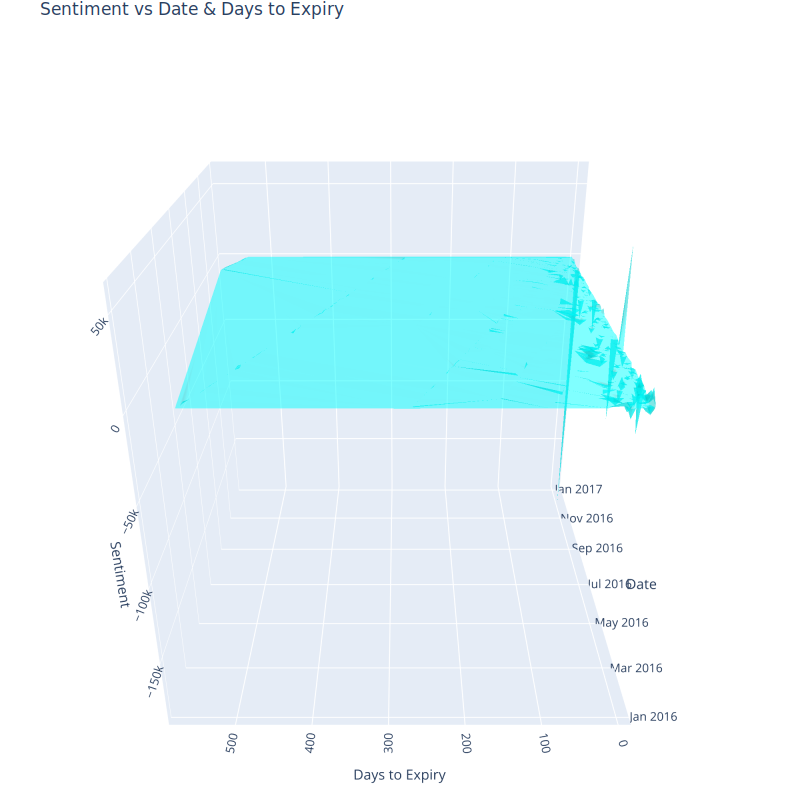

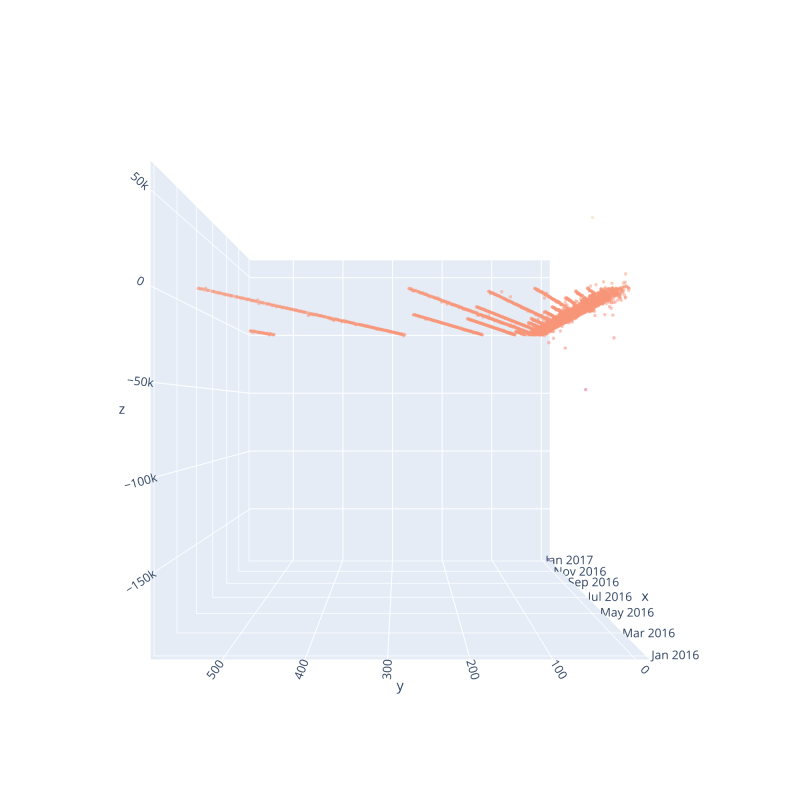

In [8]:
fig = go.Figure(data=[go.Mesh3d(x=options_senti["date"],
                                y=options_senti["days till exp"],
                                z=options_senti["combined senti day"],
                                opacity=0.5,
                                color="cyan")])

fig1 = go.Figure(data=[go.Scatter3d(
    x=options_senti["date"],
    y=options_senti["days till exp"],
    z=options_senti["combined senti day"],
    mode='markers',
    marker=dict(
        size=2,
        color=options_senti["combined senti day"],
        opacity=0.5,
        colorscale="agsunset",
        showscale=False
    )
)])

fig.update_layout(scene=dict(
    xaxis_title="Date",
    yaxis_title="Days to Expiry",
    zaxis_title='Sentiment'),
    margin=dict(t=30, r=0, l=0, b=0),
    font=dict(size=12),
    scene_camera=dict(eye=dict(x=-2, y=0, z=1)),
    title="Sentiment vs Date & Days to Expiry")

fig1.update_layout(font=dict(size=12),
                   scene_camera=dict(eye=dict(x=-2, y=0, z=0)))

fig.show("svg", width=800, height=800)
fig1.show("svg", width=800, height=800)  # fig.show("svg", width=900, height=600)

**Observations**

From looking at the call and put option "sentiment" as seen above, we observe "spikes" in sentiment. I speculate that call exercises that happened shortly before ex-dividend dates cause these spikes. In the example of `CVX`, there were spikes on 04-28, 05-16, 08-16 and 11-15. The ex-dividend dates were 02-16, 05-17, 08-17 and 11-16 of that year. This happens with stocks that are dividend heavy, as in the case with `CVX`.

Future improvement: Remove all options where obvious exercising took place. Note that extreme values of sentiment do not necessarily indicate exercise. Extremely negative values of call sentiment immediately before ex-div dates, or positive put sentiment immediately on/after ex-div dates could imply exercise.

**Feature Binning**

Ultimately, we want to create a model that uses the sentiment value of each day as a unique feature. For instance, the sentiment for 1 day till expiry is one feature, 2 days till expiry being another feature ...etc. However, we realize that, given that almost all options expire on the Friday of each week, and with the furthest option being more than 2 years out in some cases, there are simply too many features. There would be roughly over 600 features, with all except roughly 10 of those being 0's on a given day. In addition, most features would only have a handful of observations with non-trivial entries. This can be seen by the sparse diagonal lines above.

I will first categorize the days till expiry by virtue of how many weeks are left. For example, I will consider 1 to 5 days till expiry as feature 1, 6 to 10 days till expiry as feature 2 ...etc. However, once we reach a certain number of weeks, the options are no longer weekly, but often have 4 or 5 weeks in between them (monthly). After this, things become quite non-standardized, sometimes followed by bi-monthly expiring options, other times with tri-monthly, but mostly with a non-uniform spacing. The last option will expire a year after the second last.

I have come up with two methods of grouping. The first and more straightforward, would be to set fixed parameters governing what a feature encompasses. For example, all options that expire between 9 and 12 weeks are considered a feature, 13 to 16 weeks being another. The advantage of this is that we would have the best understanding of what the features mean. The disadvantage being that sometimes we may have large gaps of time with no options satisfying a feature, making the data sparse. In addition, there is difficulty in deciding when we should switch from monthly grouping to bi/tri-monthly grouping ...etc. Since different tickers have different conventions on how long these intervals last, automation of selecting feature parameters is difficult. For example, AAPL might have monthly expiring options from 3 to 9 months out, but a smaller company with less volume may only have monthly expiring options from 3 to 5 months out. The second idea would be to iterate over all the days in the data and select a range such that there are no multiple observations for each day, combined with a coverage such that there are not as many empty features. However, the downside to this method is the lack of interpretability of the features, as the span of time represented by "feature x" for one stock would be different from "feature x" of another stock.

Here, I have used the first method, since it is easier to do. I have determined the ranges of suitable dates based on AAPL options, a stock with relatively many options.

Future improvement: Since options often expire on a weekly basis for the next 40 business days (2 months) on any given date, it is evident that our model needs to have good precision for days in the near future. To do this, I believe that it is beneficial to have more resolved features within that time period. (e.g. having 1 day, 2 days, 3 days till expiry as separate features).

Selected Features (all days/weeks are inclusive of both boundaries):
    1. 1 week (1-5 days)
    2. 2 weeks (6-10 days)
    3. 3 weeks (11-15 days)
    4. 4 weeks (16-20 days)
    5. 5 weeks (21-25 days)
    6. 6 weeks (26-30 days)
    7. 7 weeks (31-35 days)
    8. 8-12 weeks (36-55 days)
    9. 13-16 weeks (56-75 days)
    10. 17-20 weeks (81-100 days)
    11. 21-24 weeks (101-120 days)
    12. 25-32 weeks (121-160 days)
    13. 33-40 weeks (161-200 days)
    14. 41-51 weeks (201-255 days)
    15. 52-71 weeks (256-355 days)
    16. greater than 72 weeks (> 356 days)

Note: The day to week conversion isn't the most accurate, as it assumes the market is open 5 days a week, without any holidays.

In [9]:
temp_df = pd.DataFrame()
temp_df["date"] = adj_closing["date"]

feature_parameters = np.array([[1, 5], [6, 10], [11, 15], [16, 20],
                               [21, 25], [26, 30], [31, 35], [36, 55],
                               [56, 75], [76, 95], [96, 120], [121, 160],
                               [161, 200], [201, 255], [256, 355], [356, np.inf]])

for my_bounds in feature_parameters:
    selected_df = options_senti[(options_senti["days till exp"] >= my_bounds[0]) &
                                (options_senti["days till exp"] <= my_bounds[1])]

    # Finding dates with multiple options expiring within specified range
    dup_rows = selected_df["date"].isin(selected_df[selected_df["date"].duplicated()]["date"])
    dup_df = selected_df[dup_rows][["date", "combined senti day"]]
    sin_df = selected_df[-dup_rows][["date", "combined senti day"]]

    # Averaging the dates with multiple options & appending
    if dup_df.shape[0] != 0:
        dup_avg_df = dup_df.groupby("date").mean().reset_index()
        sin_df = sin_df.append(dup_avg_df, ignore_index=True)
        temp_df = temp_df.merge(sin_df, how="left",
                                on="date")
    else:
        temp_df = temp_df.merge(sin_df, how="left",
                                on="date")

temp_df.columns = ["date", "feat 1", "feat 2", "feat 3", "feat 4",
                   "feat 5", "feat 6", "feat 7", "feat 8",
                   "feat 9", "feat 10", "feat 11", "feat 12",
                   "feat 13", "feat 14", "feat 15", "feat 16"]

temp_df = temp_df.fillna(value=0)

options_unstack = temp_df.merge(adj_closing_ext,
                                how="left",
                                on="date")

**Splitting Data Into Training and Testing**

Before we scale our features and target variable, we will split our data into 80% training and 20% testing. No randomization will be done when splitting because we do not want "leak" test data into the training data.

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(options_unstack.iloc[:, 1:17],
                                                    options_unstack["adj closing"],
                                                    test_size=0.2,
                                                    random_state=None,
                                                    shuffle=False)

Using a Dickey-Fuller test to see if a unit root is present.

In [11]:
adfuller_og = adfuller(Y_train, regression="c", autolag="AIC")

print('ADF Statistic: %f' % adfuller_og[0])
print('p-value: %f' % adfuller_og[1])
print('Critical Values:')
for key, value in adfuller_og[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.315451
p-value: 0.622074
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575


It is clear that end of day price is not stationary. Plotting time series, autocorrelation (ACF) and partial ACF to pick appropriate detrending options.

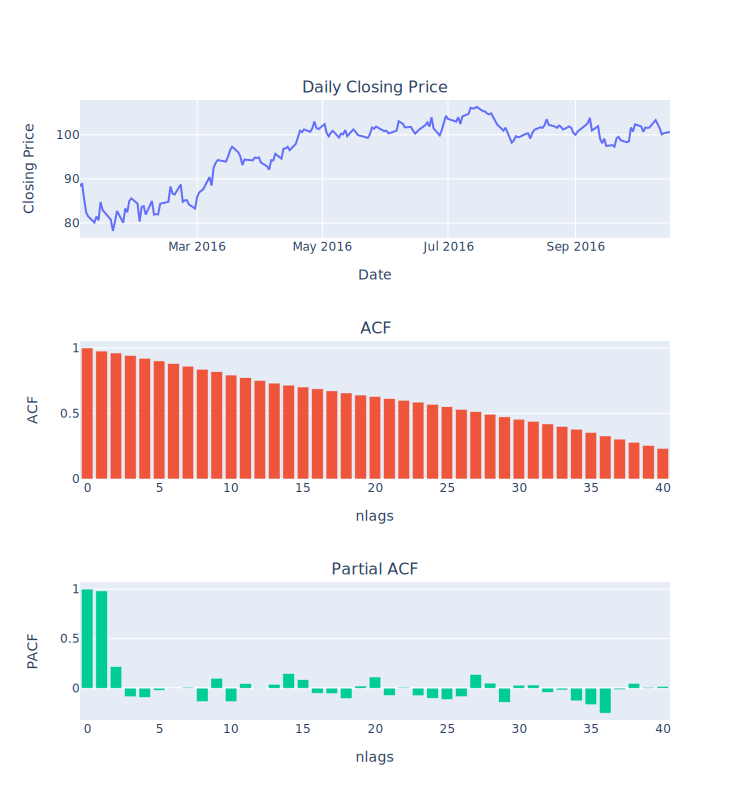

In [12]:
acf_plot = graph_fun.ts_decompose(ts=Y_train, nlags=40, dates=options_unstack["date"])
acf_plot.show("svg", width=750, height=800)

Fitting the appropriate ARIMA model for this time series. It seems that the model would benefit the most from differencing of 1 (d = 1). There does not seem to be a clear seasonality to the data (perhaps b.c. we only have 1 year of data?)

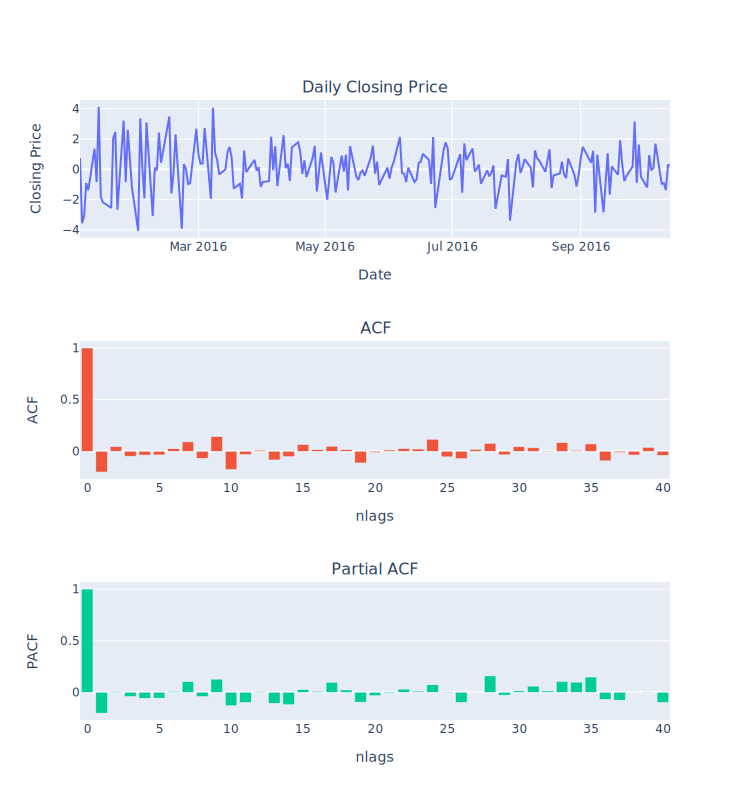

In [13]:
# Taking the difference between neighbouring observations

Y_train_l1 = Y_train[1:].reset_index(drop=True) - Y_train[:-1].reset_index(drop=True)

acf_plot_l1 = graph_fun.ts_decompose(ts=Y_train_l1, nlags=40, dates=options_unstack["date"])
acf_plot_l1.show("svg", width=750, height=800)

In [14]:
adfuller_l1 = adfuller(Y_train_l1, regression="c", autolag="AIC")

print('ADF Statistic: %f' % adfuller_l1[0])
print('p-value: %f' % adfuller_l1[1])
print('Critical Values:')
for key, value in adfuller_l1[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -17.172769
p-value: 0.000000
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575


By taking the daily change (I = 1) in end of day prices, we see that the target signal becomes stationary.

With more data, we can try to find a seasonal ARMA model that fits the residuals. This amplifies what cannot be predicted deterministically.


**Baseline Model**

Using these features, fit a simple linear regression with L2 loss function.

In [15]:
X_train_l1 = X_train.iloc[:-1]
X_test_l1 = X_test.iloc[:-1]
Y_test_l1 = Y_test[1:].reset_index(drop=True) - Y_test[:-1].reset_index(drop=True)

my_ridge = linear_model.Ridge(alpha=1)
my_ridge.fit(X=X_train_l1,
             y=Y_train_l1)

print("Coefficient of determination of the baseline model is " +
      str(np.round(my_ridge.score(X=X_test_l1, y=Y_test_l1), 4)))

Coefficient of determination of the baseline model is -0.1246


From the data, we see that the training features can be sparse. Two separate days in question may not have very different sentiment, but one may have all 16 "features", whilst another may only have 12 "features". Since empty features are filled with 0's, this can be counter-productive when fitting our model.

I will attempt to use PCA to reduce dimensionality.

In [16]:
my_pca = PCA(n_components=16)
my_pca.fit(X=X_train_l1)

print(pd.DataFrame(my_pca.components_).head())

         0         1         2         3         4         5         6   \
0  0.996331 -0.010814 -0.000698 -0.000613  0.084236 -0.004313 -0.001345   
1 -0.008555 -0.976578  0.019762 -0.004691 -0.028749  0.014266 -0.201472   
2 -0.011815  0.017981 -0.009980  0.013840  0.055677  0.312006 -0.020438   
3  0.083184  0.021100 -0.045134  0.000833 -0.990029 -0.031386  0.043952   
4 -0.010378  0.022489  0.015073  0.018225  0.043701 -0.936510 -0.163712   

         7         8         9         10        11        12        13  \
0  0.009059  0.000255  0.002497 -0.000650  0.000092  0.000723 -0.000071   
1  0.012072  0.002746  0.012690 -0.061840  0.000062  0.000816 -0.003515   
2  0.947475  0.016644  0.005893  0.013543  0.010148  0.000022  0.003198   
3  0.070032  0.016485 -0.012243 -0.036196 -0.023990 -0.000687  0.005814   
4  0.301618  0.005194 -0.035978  0.000993 -0.002866  0.004984  0.001557   

         14        15  
0 -0.000545  0.000617  
1  0.001043  0.006056  
2  0.005013  0.006259  
3 

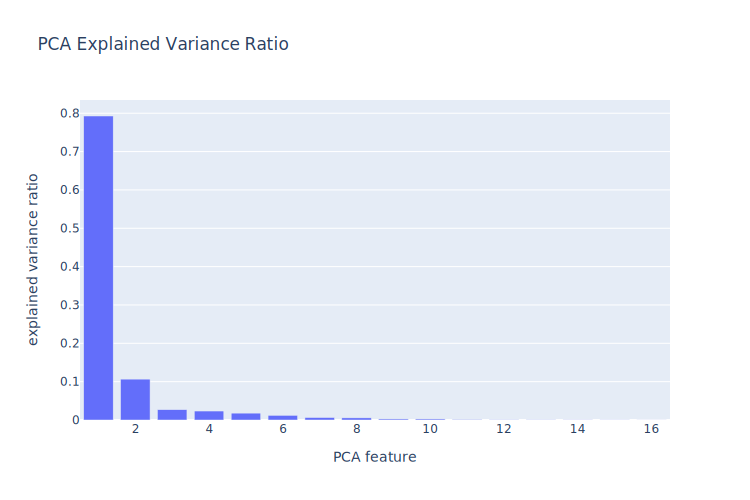

In [17]:
pca_df = pd.DataFrame(data={"explained variance ratio": my_pca.explained_variance_ratio_,
                            "PCA feature": np.linspace(1, 16, 16)})

pca_fig = px.bar(pca_df, x="PCA feature", y="explained variance ratio", title="PCA Explained Variance Ratio")

pca_fig.show("svg", width=750, height=500)

From the PCA vectors, we see that the majority of the variance is explained by feat. 1 (1-5 days till expiry), followed by feat. 2 (6-10 days), feat 3 (11-15 days) ...etc. This suggests that options expiring soon vary widely in sentiment.

This may seem counter-intuitive, as one may expect the room for fluctuation to become more narrow as expiration approaches, and expand the further out we go. This is largely due to the high volume (thus weight) of options expiring soon.

In [18]:
X_train_pca = my_pca.transform(X_train_l1)[:, :5]
X_test_pca = my_pca.transform(X_test_l1)[:, :5]

my_ridge_pca = linear_model.Ridge(alpha=1)
my_ridge_pca.fit(X=X_train_pca,
                 y=Y_train_l1)

print("Coefficient of determination of the baseline model is " + str(
    np.round(my_ridge_pca.score(X=X_test_pca, y=Y_test_l1), 4)))

Coefficient of determination of the baseline model is -0.0831


In [19]:
my_KN = KNeighborsRegressor(weights="uniform",
                            algorithm="brute")

my_KN.fit(X_train_pca, Y_train_l1)

print(my_KN.score(X_test_pca, Y_test_l1))


-0.5487829814710878


**K-Nearest Neighbours Regression Approach**

Interesting concepts to look into:
    - Neighbourhood components analysis
    - Large margin nearest neighbor
    - Mahalanobis distance
    - Sparse PCA

In [1]:
# lead_1 = adj_closing_ext["lead 2"][1:-2]
# lead_1_1 = adj_closing_ext["lead 2"][:-3]
#
# np.corrcoef(x=lead_1_1, y=lead_1)
